In [1]:
import os
import random
import numpy as np
import itertools as it
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader, Subset

In [2]:
from torchvision.utils import make_grid

In [3]:
from constants import path_to_data, num_images, num_rotations, patch_size, max_size, label_name_to_value, to_name
from utils import load_png_tuple
from augmentation import *
from show import *

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
%load_ext line_profiler

In [6]:
SEED = 238122

In [7]:
def lenghts_split(size, perc):
    train_l =  int(0.9 * size)
    return train_l, size - train_l

In [8]:
random.seed(SEED)

n_img_train, n_img_val = lenghts_split(num_images, .9)

img_indices = np.random.permutation(num_images)
train_ind = img_indices[:n_img_train]
val_ind = img_indices[n_img_train:]

assert len(val_ind) == n_img_val
len(train_ind), len(val_ind)

(376, 42)

In [9]:
from dataset import FacadesDatasetRandomRot, TransformedDataset

In [10]:
dset = FacadesDatasetRandomRot(
    img_dir='{}/images/rot_aug_{}'.format(path_to_data, max_size),
    caching=True,
    #init_caching=True,
)

In [21]:
def random_crop(img, lbl, crop_size=patch_size):
    assert type(img) is torch.Tensor
    
    if type(crop_size) is int:
        crop_x, crop_y = crop_size, crop_size
    else:
        crop_x, crop_y = crop_size
        
    h,w = img.shape[1:]
    top = random.randint(0, h-crop_y)
    left = random.randint(0, w-crop_x)
    return img[:, top:top+crop_y, left:left+crop_x],\
            lbl[:, top:top+crop_y, left:left+crop_x].long()

We train with random crop of size 256x256

In [22]:
dset_train = TransformedDataset(
    dataset=dset,
    transform=random_crop,
)

We validate on random crop of size which multiple of 256 (model constraint)

In [23]:
def closest_multiple(val, m=64):
    n = 0
    while m * n <= val:
        n += 1
    return m * (n-1)

In [24]:
def crop_size(img):
    return tuple(closest_multiple(s) for s in img.shape[1:])[::-1]

In [25]:
dset_val = TransformedDataset(
    dataset=dset,
    transform=lambda img,lbl: random_crop(img, lbl, crop_size=crop_size(img)),
)

(826, 1024, 3) (826, 1024, 1)


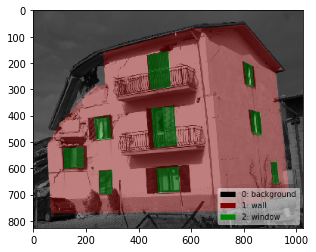

In [26]:
show_labeled_img(*dset[0])

(256, 256, 3) (256, 256, 1)


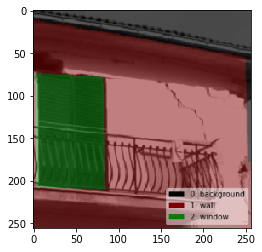

In [27]:
show_labeled_img(*dset_train[0])

(768, 1024, 3) (768, 1024, 1)


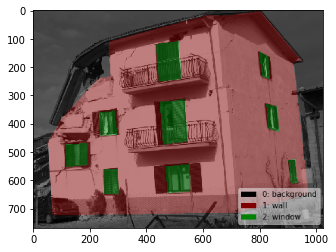

In [28]:
show_labeled_img(*dset_val[0])

## Stats

Weights are not fixed (random crop is applied)

# Model

## DataLoaders

In [30]:
train_dataset = Subset(dset_train, train_ind)
val_dataset = Subset(dset_val, val_ind)

In [31]:
train_batch_size = 8

In [32]:
def to_dataloader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [33]:
dataloaders = {'train': to_dataloader(train_dataset, train_batch_size), 'val': to_dataloader(val_dataset, 1)}

In [34]:
dataset_sizes = {phase: len(dataloaders[phase]) for phase in ['train', 'val']}

In [35]:
dataset_sizes

{'train': 47, 'val': 42}

(518, 1034, 3) (518, 1034)


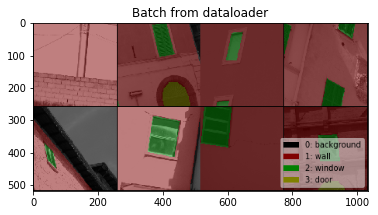

In [39]:
show_batch(*next(iter(dataloaders['train'])), label_name_to_value, 4)

## Training

In [40]:
from models import AlbuNet
from train import train_model
from loss_and_metric import dice_loss, jaccard_index

from tensorboardX import SummaryWriter
import torch.optim as optim
from torch.optim import lr_scheduler

In [41]:
def load_model_weights(model, model_name, epoch):
    model_path = '{}/models/model_{}_{}.torch'.format(path_to_data, model_name, epoch)
    model.load_state_dict(torch.load(model_path))
    if hasattr(model, 'epoch_trained'):
        model.epoch_trained = epoch

In [42]:
albunet = AlbuNet(
    num_classes=len(label_name_to_value),
    num_filters=16,
    pretrained=True,
    is_deconv=False,
).to(device)

In [44]:
model_name = 'albunet_dice_aug'
criterion = dice_loss
#criterion = torch.nn.CrossEntropyLoss(weights)
optimizer = optim.Adam(albunet.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [45]:
import datetime
import pytz

timezone = pytz.timezone(pytz.country_timezones['ch'][0])
date_time = datetime.datetime.now(tz=timezone).strftime("%Y-%m-%d_%H-%M-%S")

In [46]:
#load_model_weights(albunet, model_name, 200)

In [47]:
albunet = train_model(
    device=device,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    path_to_data=path_to_data,
    model_name=model_name,
    model=albunet,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=exp_lr_scheduler,
    writer=SummaryWriter('runs/{}_{}.log'.format(model_name, date_time)),
    num_epoch=200,
)

Epoch [1/200] train: 13/47 batch
Training complete in 0m 8s
Best val Loss: 9223372036854775808.000000
Best val Jacc: 0.000000


In [139]:
load_model_weights(albunet, model_name, 111)

# Showing Predictions

In [179]:
import pickle

from utils import path_to_tuple
from constants import mean, std

In [180]:
img_dir = '{}/labels'.format(path_to_data)
img_paths = [os.path.join(img_dir, fname) for fname in sorted(os.listdir(img_dir))]
img, lbl = path_to_tuple(img_paths[185], label_name_to_value)

(3024, 4032, 1)


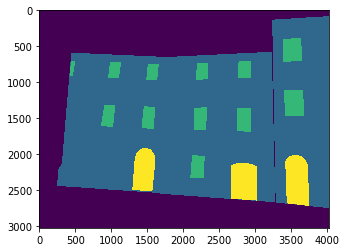

In [181]:
show_img(lbl)

In [182]:
def val_img_predict(idx):
    image, label_true = dset_val[idx]
    output = albunet(image.unsqueeze(0).to(device))
    _, label_pred = torch.max(output, 1)
    return image, label_pred, label_true

In [183]:
pred_stats = dict()
for idx in val_ind:
    _, pred, target = val_img_predict(idx)
    acc_jaccard = jaccard_index(pred, target.squeeze(), n_classes=len(target.unique()))
    pred_stats[idx] = acc_jaccard.mean()
pred_stats

{250: tensor(0.3169),
 209: tensor(0.1860),
 293: tensor(0.1991),
 78: tensor(0.2615),
 79: tensor(0.3028),
 402: tensor(0.3090),
 10: tensor(0.0608),
 129: tensor(0.2314),
 384: tensor(0.2426),
 342: tensor(0.1540),
 365: tensor(0.2079),
 265: tensor(0.3248),
 103: tensor(0.3610),
 197: tensor(0.2452),
 94: tensor(0.4355),
 113: tensor(0.1971),
 33: tensor(0.1572),
 145: tensor(0.2376),
 193: tensor(0.2289),
 173: tensor(0.3185),
 238: tensor(0.2202),
 138: tensor(0.1932),
 392: tensor(0.3019),
 76: tensor(0.2041),
 131: tensor(0.2482),
 380: tensor(0.2731),
 366: tensor(0.2442),
 168: tensor(0.2705),
 176: tensor(0.2988),
 32: tensor(0.1014),
 120: tensor(0.1094),
 161: tensor(0.1996),
 385: tensor(0.2974),
 379: tensor(0.2483),
 44: tensor(0.2296),
 217: tensor(0.2620),
 90: tensor(0.2327),
 152: tensor(0.4162),
 273: tensor(0.2192),
 360: tensor(0.2593),
 150: tensor(0.2816),
 29: tensor(0.0497)}

In [192]:
def show(idx):
    img, label_pred, label_true = val_img_predict(idx)
    acc_jaccard = jaccard_index(label_pred, label_true.squeeze(), n_classes=len(label_true.unique()))
    print(idx, acc_jaccard)
    """
    for chan in range(3):
        img[chan] *= torch.tensor(std)[chan]
        img[chan] += torch.tensor(mean)[chan]
    """
    show_img(img)
    show_img(label_pred.cpu())
    show_img(label_true.cpu())

94 tensor([0.0000, 0.9144, 0.4094])
torch.Size([1024, 640, 3])


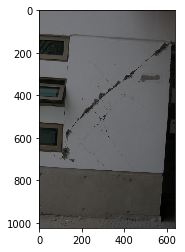

torch.Size([1024, 640, 1])


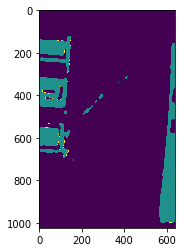

torch.Size([1024, 640, 1])


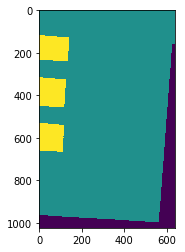

In [193]:
show(max(pred_stats.items(), key=lambda x:x[1])[0])

29 tensor([0.0000, 0.0924, 0.0229])
torch.Size([832, 1024, 3])


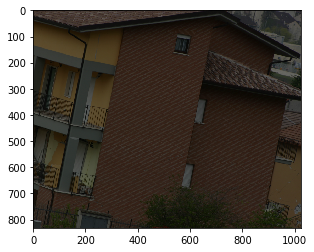

torch.Size([832, 1024, 1])


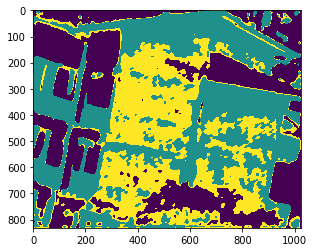

torch.Size([832, 1024, 1])


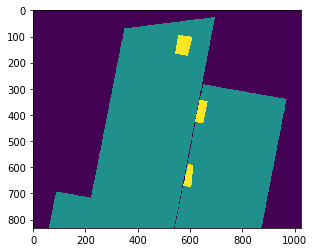

In [194]:
show(min(pred_stats.items(), key=lambda x:x[1])[0])

25 tensor([0.0000, 0.6934, 0.4572])
torch.Size([640, 1024, 3])


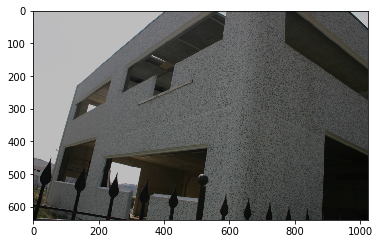

torch.Size([640, 1024, 1])


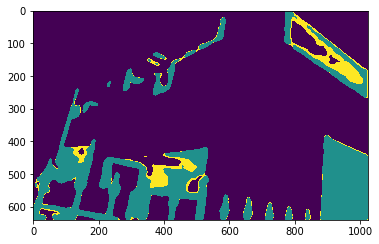

torch.Size([640, 1024, 1])


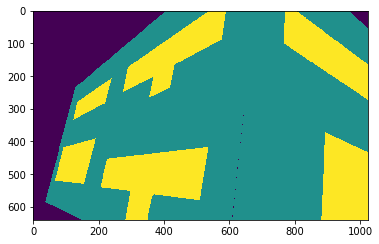

In [195]:
show(25)